In [1]:
%load_ext autoreload
%autoreload 2
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate
from langchain_core.messages import HumanMessage, AIMessage, AIMessageChunk
from langchain.memory import ConversationBufferMemory
from langgraph.graph import StateGraph, END, START, MessagesState
from langchain_experimental.tools.python.tool import PythonAstREPLTool
import dotenv
import pandas as pd
import config
import matplotlib.pyplot as plt
import seaborn as sns
import utils
from typing import Sequence, Literal
from typing_extensions import Annotated, TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from langgraph.prebuilt import create_react_agent
from langchain_community.tools import DuckDuckGoSearchRun
from langgraph.types import Command
dotenv.load_dotenv()

True

In [2]:
df = pd.read_csv("clean-food.csv")

In [3]:
recipe_prompt = ChatPromptTemplate(
    [
        ("system", config.AGENT_PROMPT_RECIPE),
        ("placeholder", "{messages}"),
    ],
    partial_variables={"df_str": df.to_markdown(index=True)},  # Include the dataframe as markdown
)

In [4]:
visualize_prompt = ChatPromptTemplate(
    [
        ("system", config.AGENT_PROMPT_VISUALIZATION),
        ("placeholder", "{messages}"),
    ]
)

In [5]:
# system_prompt = "You are a helpful bot named Fred."

In [6]:


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    is_last_step: str

In [7]:
recipe_agent = create_react_agent(
    model=utils.get_llm(),
    tools=[DuckDuckGoSearchRun()],
    state_modifier=recipe_prompt,
    # state_schema=AgentState
)


In [8]:
async def recipe_node(state: MessagesState) -> Command:
    result = await recipe_agent.ainvoke(state)
    return {"messages": result} 
    # return  
    # Command(
    #     update={
    #         "messages": [
    #             AIMessageChunk(content=result["messages"][-1].content, name="recipe_node")
    #         ]
    #     },
    #     # goto="visual_agent",
    # )


In [9]:
visual_agent = create_react_agent(
    model=utils.get_llm(),
    tools=[PythonAstREPLTool()],
    state_modifier=visualize_prompt,
    # state_schema=AgentState
)

In [10]:
async def visual_node(state: MessagesState) -> Command:
    result = await visual_agent.ainvoke(state)
    return {"messages": result} 
    # Command(
    #     update={
    #         "messages": [
    #             AIMessageChunk(content=result["messages"][-1].content, name="visual_node")
    #         ]
    #     },
    #     # goto="supervisor",
    # )

In [11]:
graph = StateGraph(MessagesState)
graph.add_node("recipe_node", recipe_node)
graph.add_node("visual_node", visual_node)
# graph.add_edge(START, "recipe_node")
graph.add_edge("recipe_node", "visual_node")
# graph.add_edge("visual_node", END)
# graph.add_edge("visual_node", END)

graph.set_entry_point("recipe_node")
graph.set_finish_point("visual_node")

workflow = graph.compile()

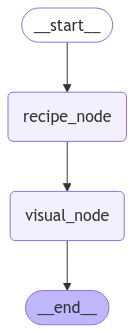

In [12]:
from IPython.display import display, Image
Image(workflow.get_graph().draw_mermaid_png())

In [13]:
df[df['Food'].str.contains("cheese")]

,Food,Nutrition Value (per 100g),Quantity,Originated From,Calories,Protein (g),Fiber (g),Vitamin C (mg),Antioxidant Score,Quantity (g)


In [14]:
inputs = {
    "messages": [HumanMessage(content="I have Tomatoes, and Paneer. What can I make and how? Can you please search the internet and tell me?")]
}

In [15]:
# for s in workflow.stream(inputs, stream_mode="messages-tuple"):
first = True
async for msg, metadata in workflow.astream(inputs, stream_mode="messages"):
    if msg.content and not isinstance(msg, HumanMessage):
        print(msg.content, end="|", flush=True)

    if isinstance(msg, AIMessageChunk):
        if first:
            gathered = msg
            first = False
        else:
            gathered = gathered + msg

        if msg.tool_call_chunks:
            print(gathered.tool_calls)
    # message = s["messages"][-1]
    # if isinstance(message, tuple):
    #     print(message)
    # else:
    #     # print(tool_calls)
    #     message.pretty_print()

ValueError: Message dict must contain 'role' and 'content' keys, got {'messages': [HumanMessage(content='I have Tomatoes, and Paneer. What can I make and how? Can you please search the internet and tell me?', additional_kwargs={}, response_metadata={}, id='65a8d428-e92a-43af-914c-7f4c0c5ea9a4'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'duckduckgo_search', 'arguments': '{"query": "paneer tomato recipe"}'}}, response_metadata={'safety_ratings': [], 'finish_reason': 'STOP'}, id='run-2d840ae0-e5be-41fe-a654-c00c15061513-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': 'paneer tomato recipe'}, 'id': '0d271213-5172-4c16-b525-b94838c6a907', 'type': 'tool_call'}], usage_metadata={'input_tokens': 5889, 'output_tokens': 10, 'total_tokens': 5899}), ToolMessage(content='This Paneer Butter Masala recipe is a rich and creamy dish of paneer (Indian cottage cheese) in a tomato, butter and cashew sauce that is known here as "makhani gravy." The acidity of the tomatoes and the sweetness of the cream make for a velvety, nearly addictive sauce. Paneer Butter Masala is one of India\'s most popular paneer gravy recipes, and with good reason! Indian cottage cheese cubes are smothered in a creamy, lightly spiced tomato sauce that is downright delicious. With my video and step-by-step guide you can easily make this restaurant style Paneer Butter Masala recipe at home! About Paneer Butter About Paneer Makhani Recipe. Paneer Makhani is a delectable, traditional Indian dish made with cubes of cheese cooked in a rich and creamy tomato based sauce. The word makhani means "buttery," and is derived from the word makhan which means "homemade butter." This dish is the vegetarian version of Murgh Makhani, which is commonly known ... Pour in tomato purée and ketchup: Pour in 1 (14.25 ounce) can tomato puree and 1 tablespoon ketchup; thin with water to desired consistency. Stir in peas and paneer: Stir in 1 (16 ounce) package frozen peas, thawed, and 8 ounces paneer, cubed; cook until peas soften, 2 to 3 minutes. Paneer: Use store-bought paneer from the Indian grocery store here in the USA (refrigerated or frozen section).To soften paneer, soak in warm water for 10-15 minutes before use. You can also make fresh paneer at home if time permits.; Green Peas: Frozen peas are convenient and work well; fresh peas are an excellent choice if available.; Onion: Use red onions for the best flavor in Indian cooking.', name='duckduckgo_search', id='34ece44c-11ee-48dc-bd4e-336c096a461d', tool_call_id='0d271213-5172-4c16-b525-b94838c6a907'), AIMessage(content='Okay, I will create a recipe for Paneer Butter Masala, drawing inspiration from the search results, but focusing on a healthier approach.\n\n**Recipe Name:** Healthier Paneer Tomato Masala\n\n**Description:** A creamy and flavorful Indian dish with paneer (Indian cheese) in a rich tomato-based sauce, made healthier with less butter and cream.\n\n**Ingredients:**\n\n*   1 tbsp Olive Oil (19)\n*   1 medium Onion, chopped (66)\n*   2 cloves Garlic, minced (3)\n*   1 inch Ginger, grated (18)\n*   1 tsp Turmeric powder (12)\n*   1 tsp ground Cumin\n*   1/2 tsp ground Coriander\n*   1/4 tsp Cayenne Pepper (74)\n*   1 (14.5 oz) can diced Tomatoes (23)\n*   1/2 cup Water\n*   8 oz Paneer, cubed\n*   1/4 cup Greek Yogurt (15)\n*   1/4 cup chopped Cilantro\n*   Salt to taste\n\n**Instructions:**\n\n1.  **Sauté Aromatics:** Heat olive oil in a pan over medium heat. Add chopped onion and sauté until golden brown. Add minced garlic and grated ginger, and cook for another minute until fragrant.\n2.  **Add Spices:** Stir in turmeric powder, cumin, coriander, and cayenne pepper. Cook for 30 seconds until fragrant.\n3.  **Tomato Base:** Add diced tomatoes and water. Bring to a simmer, then reduce heat and cook for 10 minutes, stirring occasionally, until the sauce thickens slightly.\n4.  **Add Paneer:** Gently add the cubed paneer to the sauce. Simmer for 5 minutes, allowing the paneer to absorb the flavors.\n5.  **Creamy Finish:** Stir in the Greek yogurt and chopped cilantro. Cook for another 2 minutes. Season with salt to taste.\n6.  **Serve:** Serve hot with brown rice or whole wheat roti.\n\n**Prep Time:** 15 minutes\n**Cook Time:** 25 minutes\n**Total Time:** 40 minutes\n\n**Nutritional Analysis (per serving, assuming 4 servings):**\n\n*   **Calories:** Approximately 300-350\n*   **Protein:** 20-25g\n*   **Fat:** 15-20g\n*   **Carbohydrates:** 20-25g\n*   **Fiber:** 5-7g\n\n**Notes:**\n\n*   For a richer flavor, you can add a small amount of butter (1 tsp) along with the olive oil.\n*   Adjust the amount of cayenne pepper to your spice preference.\n*   You can add a pinch of garam masala at the end for extra flavor.\n*   Serve with a side of brown rice or whole wheat roti for a complete meal.\n\nThis recipe provides a balance of protein, healthy fats, and complex carbohydrates, making it a nutritious and satisfying meal.\n', additional_kwargs={}, response_metadata={'safety_ratings': [], 'finish_reason': 'STOP'}, id='run-9325198c-ff08-4fce-8c39-c4f02609e9f0-0', usage_metadata={'input_tokens': 6275, 'output_tokens': 641, 'total_tokens': 6916})]}
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/MESSAGE_COERCION_FAILURE 